# Segment 2 - Activation Maximization

In Segment 1, we treated a CNN as a hierarchy of feature detectors:
early layers respond to local patterns, while deeper layers combine those patterns into more abstract representations.

In this segment, we flip the usual perspective. Instead of asking "What does the network do with this image?" we ask "What kind of image would maximally activate this neuron?".

This technique is called **activation maximization**, and it gives us a direct, though imperfect, window into what individual neurons and channels respond to.

## 1️⃣ Activation maximization

Activation maximization works by starting from a random image and **optimizing the input pixels** so as to maximize the activation of a chosen neuron or channel inside the network. Nothing in the model is changed. 

Let's start with the set-up:

In [5]:
import torch
import torchvision.models as models
import matplotlib.pyplot as plt

from lucent.optvis import render, param, objectives
import lucent.modelzoo.inceptionv1 as inceptionv1

In [6]:
# Load pretrained InceptionV1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = inceptionv1(pretrained=True).to(device).eval()
model.eval()

Downloading: "https://github.com/ProGamerGov/pytorch-old-tensorflow-models/raw/master/inception5h.pth" to C:\Users\joana/.cache\torch\hub\checkpoints\inception5h.pth


100%|██████████| 27.0M/27.0M [00:00<00:00, 38.0MB/s]


InceptionV1(
  (conv2d0_pre_relu_conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2))
  (conv2d1_pre_relu_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv2d2_pre_relu_conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1))
  (mixed3a_1x1_pre_relu_conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
  (mixed3a_3x3_bottleneck_pre_relu_conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
  (mixed3a_5x5_bottleneck_pre_relu_conv): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
  (mixed3a_pool_reduce_pre_relu_conv): Conv2d(192, 32, kernel_size=(1, 1), stride=(1, 1))
  (mixed3a_3x3_pre_relu_conv): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1))
  (mixed3a_5x5_pre_relu_conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (mixed3b_1x1_pre_relu_conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (mixed3b_3x3_bottleneck_pre_relu_conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (mixed3b_5x5_bottleneck_pre_relu_conv): Conv2d(256, 32, 

## 2️⃣ Choosing what to optimize: the `mixed4a` layer

In Inception-style architectures, mixed layers combine multiple convolutional paths. This makes them especially interesting for interpretability: they are neither too low-level nor fully semantic.

We will target `mixed4a` and optimize individual channels inside this layer. In Lucent, this is expressed using an **objective**

## 3️⃣ Visualizing the first 10 channels

Below, we generate activation maximizations for channels **0-9** of the `mixed4a` layer. Each image answer the question: "What kind of input most excites this channel?"

100%|██████████| 512/512 [02:14<00:00,  3.81it/s]


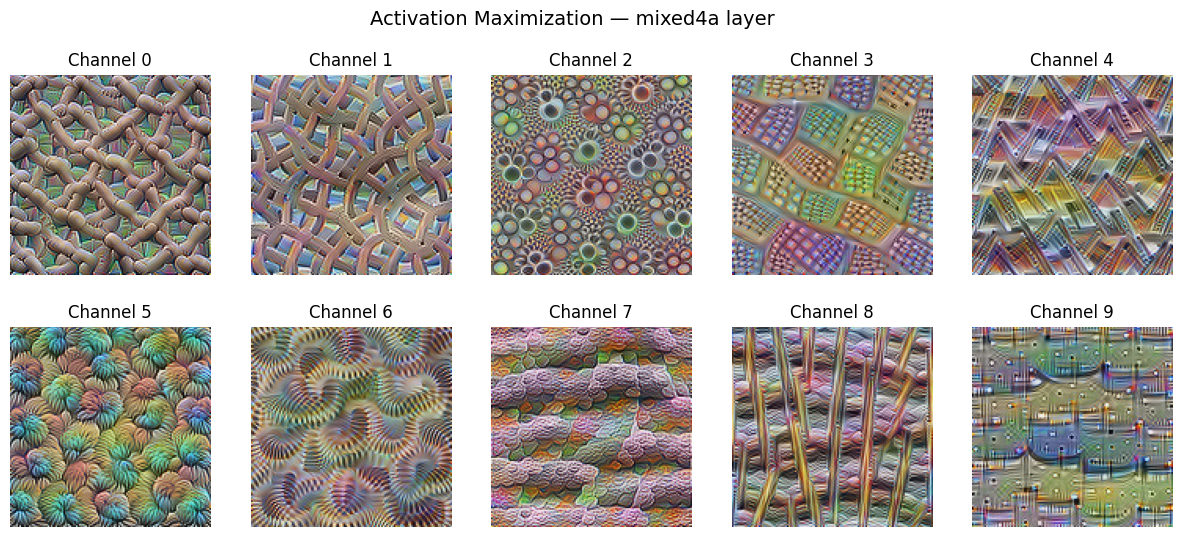

In [7]:
layer = "mixed4a"

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for channel in range(10):
    objective = objectives.channel(layer, channel)
    param_f = lambda: param.image(128)

    images = render.render_vis(
        model,
        objective,
        param_f,
        show_image=False
    )

    ax = axes[channel // 5, channel % 5]
    ax.imshow(images[0][0, :, :, :3])
    ax.set_title(f"Channel {channel}")
    ax.axis("off")

plt.suptitle("Activation Maximization — mixed4a layer", fontsize=14)
plt.show()


## 4️⃣ How should we read these images?

It's tempting to look for objects ("this looks like a face!"), but that's often misleading. A better whay to reason about these visualizations is to understand that they're not dataset images, they are **synthetic inputs** optimized to excite a neuron, with high-frequency textures or repeated motifs being common. Each channel's activation maximizing image looks different.

Some guiding questions to ask:
- Do different channels respond to clearly different structures?
- Are patterns more textual or more shape-like?
- How stable ae these results if you rerun the optimization?

## 5️⃣ Important caveats

Activation maximization is imperfect. A few things to keep in mind: 
- Optimized images can exploit model quirks. 
- Results depend on:
    - Initialization
    - Image parameretization
    - Regularization choices
- A neuron's visualization is not it's full meaning

Interpretability is about building constrainst on what explanations are possible, not about finding _the_ explanation. 

## 🧩 Takeaways from Segment 2

From this exercise, we learn that:

- Individual channels act as feature detectors
- Activation maximization provides a direct probe into internal representations
- Visualizations are sensitive to modeling and optimization choices

With this intuition in place, we are now ready to move beyond individual neurons and toward model-level explanations — where features interact, compete, and combine.